<a href="https://colab.research.google.com/github/amrithacode/P1_BasicImageClassificationwithTensorFlow/blob/main/Aerial_Image_Segmentation_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch #take pretrained model of Unet
!pip install -U git+https://github.com/albumentations-team/albumentations #alb for data augmentation
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-fnviktn_
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-fnviktn_
  Resolved https://github.com/albumentations-team/albumentations to commit 759d8de18732881a9e12c56f313fe84e35558841
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# About Dataset

### Dataset

Here the dataset which we are going to use in this guided project is the subset(200 images and its masks) of the original dataset (Massachusetts Roads Dataset) consists of 1171 aerial images of the state of Massachusetts. Each image is 1500×1500 pixels in size, covering an area of 2.25 square kilometers

### Full Dataset

After compeletion of this project you can try the same pipeline on full dataset

https://www.cs.toronto.edu/~vmnih/data/

```
@phdthesis{MnihThesis,
author = {Volodymyr Mnih},
title = {Machine Learning for Aerial Image Labeling},
school = {University of Toronto},
year = {2013}
}
```

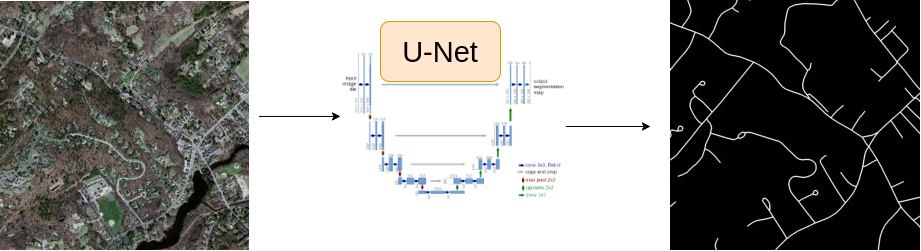

# Download Subset Dataset

In [ ]:
!git clone https://github.com/parth1620/Road_seg_dataset.git #subset with 200 images, original has 1000plus

fatal: destination path 'Road_seg_dataset' already exists and is not an empty directory.


# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Road_seg_dataset') #managnf file path, command line arg like LR

In [ ]:
import torch #tensor, face module.nn, backward()
import cv2 #face detectn, imag, edg processng

import numpy as np
import pandas as pd #structured data, matplotlib, feature engg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split #1hot encode .transform()
from tqdm import tqdm #progess bar of iterative/ loops

import helper #code reusablty, here for visualaztn fn

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Road_seg_dataset/train.csv'
DATA_DIR = '/content/Road_seg_dataset/'
DEVICE = 'cuda'
EPOCHS = 25
LR = 0.003
BATCH_SIZE = 8
IMG_SIZE = 512 #h and w is 512
ENCODER = 'timm-efficientnet-b0' #enc transform raw data into a lower-dimensional, more informative representation that can be easily processed by other parts of a model
WEIGHTS = 'imagemnet' #pre-trained weights of a neural network that has been trained on the ImageNet dataset


In [ ]:
df = pd.read_csv(CSV_FILE)
df.head() #will get img n mask PATHS

,images,masks
0,images/17428750_15.png,masks/17428750_15.png
1,images/23279080_15.png,masks/23279080_15.png
2,images/24179185_15.png,masks/24179185_15.png
3,images/24179035_15.png,masks/24179035_15.png
4,images/11128810_15.png,masks/11128810_15.png


In [ ]:
idx = 3 #3 ROW OF ABOVE OP
row = df.iloc[idx]
image_path = DATA_DIR + row.images #takes path frm above op of coloumn named imags
mask_path = DATA_DIR +row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #openCV reads in BGR

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255 #we want it in grey scale n normalised

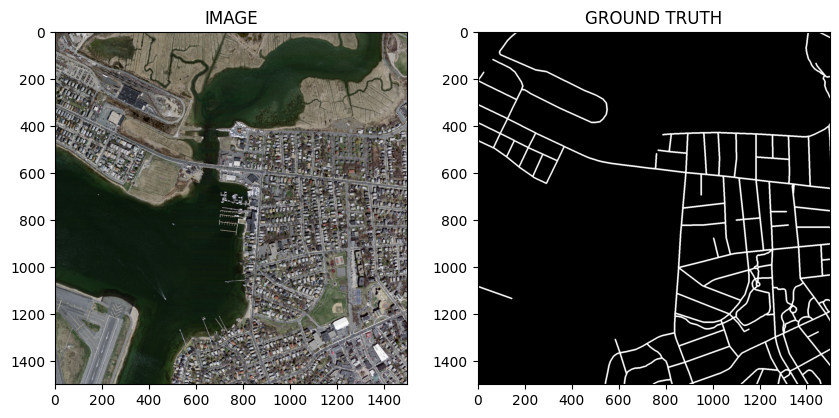

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
#to split dataset to train n valid
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)
len(train_df)

159

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5)
])

def get_valid_augs():  #in valid set no augmntn is done
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset

In [ ]:
#so as to return image n ground truth pair whenever ind specified like above but here using clas n method

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augementations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = DATA_DIR + row.images
    mask_path = DATA_DIR + row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #hwc

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #h,w
    mask = np.expand_dims(mask, axis = -1) #hwc

    if self.augmentations: #if augmnts r true, gonna apply aug on data n mask
      data = self.augmentations(image = image, mask = mask)
      image = data['image'] #hwc==0,1,2 to 201 or chw in transpose below
      mask = data['mask']

    image = np.transpose(image, (2,0,1)).astype(np.float32) #chw
    mask = np.transpose(mask, (2,0,1)).astype(np.float32) #chw

    #convertng this Numpy array to torchtensor and scale it

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask



In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
vaildset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 159


NameError: name 'validset' is not defined

In [ ]:
idx = 69
image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

NameError: name 'validset' is not defined

In [ ]:
print(f'Total number of batches in trainloader : {len(trainloader)}')
print(f'Total number of batches in validloader : {len(validloader)}')

Total number of batches in trainloader : 20


NameError: name 'validloader' is not defined

In [ ]:
for image, masks in trainloader:
  break
  print(f"One batch of images has a shape of : {images.shape}")
  print(f"One batch of masks has a shape of : {masks.shape}")


AttributeError: 'SegmentationDataset' object has no attribute 'augmentations'

# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
import segmetation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLosses

from torch import nn

In [ ]:
class SegmentationModel(nn.Module):

    def __init__(self):
      super(SegmentationModel,self).__init__()

      self.arc = smp.Unet(
          encoder_name = ENCODER,
          encoder_weights = WEIGHTS,
          in_channels = 3,
          classes = 1,
          activation = None
      )

    def forward(self, images, masks = None):
      logits = self.arc(images)
      if masks != None:
        return logits, DiceLoss(mode = 'binary')(logits, masks) + nn.BCEWithLogitsLoss()(logits, masks)
      return logits

NameError: name 'nn' is not defined

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

NameError: name 'SegmentationModel' is not defined

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(dataloader, model, optimizer):
  model.train()
  total_loss = 0.0

for images, masks in tqdm(dataloader):
  images = images.to(DEVICE)
  masks = masks.to(DEVICE)

  optimizer.zero_grad()
  logits, loss = model(images,  maks)
  loss.backward() #got loss , find gradients
  optimizer.step() #update weights n biases parametrs of d model

  total_loss += loss.item()

return total_loss / len(dataloader)


NameError: name 'dataloader' is not defined

In [ ]:
def eval_fn(dataloader, model):
  model.eval()
  total_loss = 0.0

with torch.nograd():
    for images, masks in tqdm(dataloader):
       images = images.to(DEVICE)
       masks = masks.to(DEVICE)
       logits, loss = model(images, masks)
       total_loss += loss.item()
     return total_loss / len(dataloader)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 11)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn_validloader, model

  if valid_loss < best_loss:
    print("SAVED MODEL")
    best_loss = valid_loss

    print(f"Epoch : {i+1} Train Loss : {train_loss} Valid Loss : {valid_loss}")

# Task 9 : Inference

In [ ]:
#above trained model is used for sgmntatn

In [ ]:
idx = 20
model.load_state_dict(torch.load('/content.best_model.pt'))
image, mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logist_mask)
pred_mask = (pred_mask > 0.5)*1.0
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))


# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya

